In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## Cross-validation of model performance

In this notebook, we wish to cross-validate our GNN model's performance. In particular, I do want to see whether the trends we observed are reproducible across different PRNGKeys.

## Load data

We start with a pickled version of our graph data.

In [37]:
import pickle as pkl
from pyprojroot import here
from drosha_gnn.graph import to_networkx
from drosha_gnn import annotate
import pandas as pd
import janitor

In [38]:
df = (
    pd.read_csv("https://drosha-data.fly.dev/drosha/combined.csv?_stream=on&_sort=rowid&replicate__exact=1&_size=max")
    .join_apply(lambda row: to_networkx(row["dot_bracket"]), "graph")
)
df.head()

,rowid,miRNA,forward_mut,frac_avg,replicate,lowCounts_y,outlier_y,seq,fiveEnd,threeEnd,...,UGU,CNNC,dot_bracket,compact,hairpin_score,minimum_free_energy,ensemble_free_energy,basename,logit,graph
0,1,1,None,0.998386,1,0,0,GUACGGAGGCUGUUAGGCAGACACAAACUGUGAAGUGCUGUGGAUU...,10,-10,...,0,1,((((....((((((..((((.(((...(((((((((((((((((((...,23.822519,337.293747,-59.5,-0.440509,1,6.427601,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,2,None,0.998126,1,0,0,GUACGGAGGCUGUUAGGCAGCACUCGCUCCCACCUUGUCCUCACGG...,15,-13,...,0,1,(((((...(((((...))))).((((((.(((((.((.(((((.((...,22.298016,384.374378,-58.6,-0.421181,2,6.277715,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,3,3,None,0.997694,1,0,0,GUACGGAGGCUGUUAGGCAGACUCCUCAUGGCCUCACUUUUCCACU...,9,-9,...,0,0,....((((.((((...)))).))))......((((((((.((((((...,21.073267,273.538719,-71.7,-0.512519,3,6.070139,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,4,4,None,0.997542,1,0,0,GUACGGAGGCUGUUAGGCAGAAGCCUUGUGUUCCAGCCCGAGGCCU...,10,-8,...,0,0,(((((((((((..........)))))).(((((((((.((((((((...,18.817662,404.884757,-67.4,-0.511715,4,6.006048,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,5,5,None,0.997495,1,0,0,GUACGGAGGCUGUUAGGCAGCCACUGGCCCAUCUCUUACACAGGCU...,15,-13,...,0,1,(((((..((((((...)))))).(((.....(((((((((((...(...,22.285955,529.074249,-50.9,-0.362944,5,5.986989,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [45]:
entropy = pd.read_csv("https://drosha-data.fly.dev/drosha/entropy.csv?_labels=on&_stream=on&_sort=rowid&rowid__lte=847&_size=max").select_columns(["shannon_*"])

In [46]:
entropy

,shannon_1,shannon_2,shannon_3,shannon_4,shannon_5,shannon_6,shannon_7,shannon_8,shannon_9,shannon_10,...,shannon_161,shannon_162,shannon_163,shannon_164,shannon_165,shannon_166,shannon_167,shannon_168,shannon_169,shannon_170
0,0.093327,0.132150,0.132671,0.232952,0.292199,0.097116,0.093368,0.092654,0.442830,0.650076,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.032027,0.048495,0.048561,0.071540,0.203048,0.182248,0.178692,0.202356,0.087521,0.091389,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.193411,0.217418,0.175848,0.174624,0.082767,0.115770,0.114511,0.127746,0.111877,0.057724,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.061604,0.071435,0.095937,0.171910,0.266387,0.173177,0.140964,0.220340,0.408112,0.470108,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.124070,0.137540,0.102726,0.232545,0.294623,0.135824,0.001541,0.017573,0.078687,0.080727,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.078119,0.077245,0.077338,0.202875,0.247116,0.000279,0.000042,0.003764,0.076561,0.041684,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
843,0.067294,0.067470,0.068231,0.183351,0.279651,0.001304,0.000309,0.000228,0.187805,0.273305,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
844,0.018254,0.018222,0.017389,0.030802,0.329055,0.294726,0.230599,0.116600,0.011486,0.007482,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
845,0.278459,0.301325,0.302813,0.407172,0.374801,0.144067,0.234351,0.288424,0.280608,0.465083,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Annotate node entropy and node nucleotide on each of the graphs

In [47]:
from tqdm.auto import tqdm

graphs = df["graph"].to_dict()
for idx, g in tqdm(graphs.items()):
    seq = df.loc[idx]["seq"]
    g = annotate.node_nucleotide(g, seq)

    entropy_vec = entropy.loc[idx]
    g = annotate.node_entropy(g, entropy_vec)
    graphs[idx] = g

  0%|          | 0/847 [00:00<?, ?it/s]

## Prepare graph data structures for us to use

In [60]:
from drosha_gnn.data import prep_feats, prep_adjs, feat_matrix

In [61]:
feat_matrices = dict()
for idx, graph in tqdm(graphs.items()):
    feat_matrices[idx] = prep_feats(feat_matrix(graph), 170)

  0%|          | 0/847 [00:00<?, ?it/s]

In [62]:
import networkx as nx
adj_matrices = dict()
for idx, graph in tqdm(graphs.items()):
    adj_matrices[idx] = prep_adjs(np.array(nx.adjacency_matrix(graph).todense()), 170)

  0%|          | 0/847 [00:00<?, ?it/s]

In [146]:
graph_matrices = dict()
for (idx, adj), (idx2, feat) in zip(adj_matrices.items(), feat_matrices.items()):
    graph_matrices[idx] = np.concatenate([adj, feat], axis=1)

## Train test splits

We need different train-test splits in order to test the uncertainty in model performance.feat_matrices = dict()
for idx, graph in tqdm(graphs.items()):
    feat_matrices[idx] = prep_feats(feat_matrix(graph), largest_graph_size)

In [66]:
from jax.random import PRNGKey, split

k1, k2, k3, k4, k5 = split(PRNGKey(38), 5)

In [71]:
from drosha_gnn.training import train_test_split

In [86]:
import pandas as pd
import jax.numpy as np
from jax import random
from typing import Dict

def split_data(k: random.PRNGKey, graph_matrices: Dict[int, np.ndarray], df: pd.DataFrame):
    train_idxs, test_idxs = train_test_split(k1, df)
    graph_series = pd.Series(graph_matrices)
    X_train = np.stack(graph_series[train_idxs].values)
    X_test = np.stack(graph_series[test_idxs].values)
    y_train = df.loc[train_idxs, "logit"].values.reshape(-1, 1)
    y_test = df.loc[test_idxs, "logit"].values.reshape(-1, 1)
    return X_train, X_test, y_train, y_test

In [132]:
# Just test-driving
X_train, X_test, y_train, y_test = split_data(k2, graph_matrices, df)

In [133]:
y_train.shape

(592, 1)

In [134]:
from drosha_gnn.models import AttentionEverywhereGNN
from jax.tree_util import Partial

init_fun, model = AttentionEverywhereGNN(170)
model = Partial(model)
_, params = init_fun(k1, input_shape=(170, 2))

## Forward pass

In [135]:
from jax import vmap

## Training Loop

We are going to define the training loop entirely using JAX's lax.scan and vmap.

Thinking about the entire training loop as a pure function helps us avoid statefulness,
which makes modifying the code a bit easier.
It does make writing the training loop a bit more difficult though.

In each step, we want to do the following:

1. Sample a minibatch of X and y.
2. Calculate gradient of loss function w.r.t. params, conditioned on model and data,
3. Update params.

If we need to do different splits at each step, we effectively need an array of PRNG keys that we can scan over.

In [147]:
key = random.PRNGKey(99)
n_training_steps = 10
keys = random.split(key, n_training_steps)

In [208]:
keys.shape

(10, 2)

In [209]:
training_step_idxs.shape

(10, 1)

In [276]:
training_step_idxs = np.arange(n_training_steps)

Our `lax.scan`-able step function needs to have the signature f(carry, x).

`x` would be the current iteration _and_ PRNGKey together.
`carry` is something carried over from the previous step, which would be the state.
We return the thing to carry over (updated state), and a tuple of things that we want to accumulate over steps.

In [319]:
def sample(rng: random.PRNGKey, X: np.ndarray, y: np.ndarray, n=50):
    """Sample n rows from X and y.
    
    Used to generate minibatches for faster training.
    """
    indices = np.arange(len(X))
    indices = random.permutation(rng, indices)
    return X[:n], y[:n]


def step(state, i: int, X: np.ndarray, y: np.ndarray, dmseloss: Callable, get_params: Callable, update: Callable):
    """Full step function.
    
    - X, y: Our data.
    - dmseloss: Gradient of loss function.
    - get_params, update: get_params and update function from optimizer triple.
    """
    params = get_params(state)
    l, g = dmseloss(params, model, X, y)
    state = update(i, g, state)
    return state, l



def step_v2(state, idx_and_key: int, X: np.ndarray, y: np.ndarray, dmseloss: Callable, get_params: Callable, update: Callable):
    """Full step function.
    
    - X, y: Our data.
    - dmseloss: Gradient of loss function.
    - get_params, update: get_params and update function from optimizer triple.
    """
    i, key = idx_and_key
    # X, y = sample(key, X, y)
    params = get_params(state)
    l, g = dmseloss(params, model, X, y)
    state = update(i, g, state)
    return state, l

In [320]:
from jax.experimental.optimizers import adam
from jax import jit
from drosha_gnn.training import dmseloss, mseloss
from typing import Callable

opt_init, opt_update, opt_get_params = adam(5e-3)
opt_get_params = jit(opt_get_params)
adam_step = Partial(step_v2, X=X_train, y=y_train, dmseloss=dmseloss, get_params=opt_get_params, update=opt_update)
adam_step = jit(adam_step)

Time: 43.86 seconds


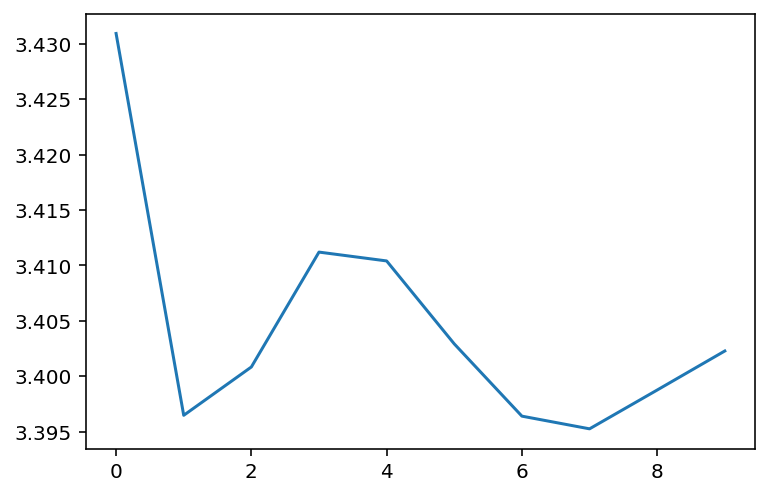

In [324]:
from time import time

start = time()
state = opt_init(params)
final_state, losses = lax.scan(adam_step, xs=(training_step_idxs, keys), init=state)
plt.plot(losses)
end = time()
print(f"Time: {end - start:.2f} seconds")

In [136]:
def train_iter(i):
    l_train, state = step(i, state, X_train, y_train)

In [137]:
from jax.experimental.optimizers import adam
from jax import jit
from drosha_gnn.training import dmseloss, mseloss
from typing import Callable

opt_init, opt_update, opt_get_params = adam(5e-3)
state = opt_init(params)
opt_get_params = jit(opt_get_params)

def step(i, state, X, y, rng: random.PRNGKey, dmseloss: Callable, get_params: Callable, update: Callable):
    """Full step function.
    
    - X, y: Our data.
    - dmseloss: Gradient of loss function.
    - get_params, update: get_params and update function from optimizer triple.
    """
    params = get_params(state)
    l, g = dmseloss(params, model, X, y)
    state = update(i, g, state)
    return (l, state)


adam_step = Partial(step, get_params=opt_get_params, update=opt_update, dmseloss=dmseloss)
adam_step = jit(adam_step)

import pickle as pkl
losses_train = []
losses_test = []
iterator = tqdm(range(200), desc="Training Loss")
states = []
for i in iterator:
    l_train, state = adam_step(i, state, X_train, y_train)
    losses_train.append(l_train)
    
    params = opt_get_params(state)
    l_test = mseloss(params, model, X_test, y_test)
    losses_test.append(l_test)
    states.append(state)

Training Loss:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

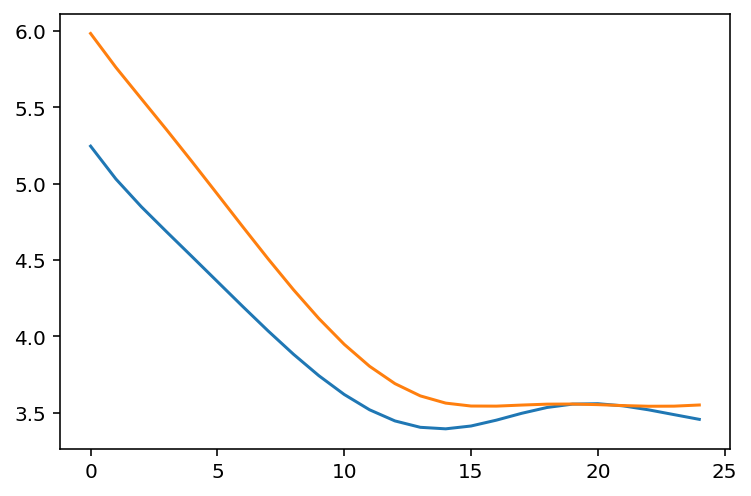

In [140]:
import matplotlib.pyplot as plt
plt.plot(losses_train)
plt.plot(losses_test)